# Linear Tests

In [30]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# %% Project bootstrap (root, imports, editable install)
from pathlib import Path
import sys, os, subprocess, importlib.util

def find_project_root(start: Path) -> Path:
    """Walk up until we see a project marker (pyproject.toml, .git, or defaults.yaml)."""
    p = start.resolve()
    markers = {"pyproject.toml", ".git", "defaults.yaml"}
    while p != p.parent:
        if any((p / m).exists() for m in markers):
            return p
        p = p.parent
    return start.resolve()

# works for both .ipynb (no __file__) and .py notebooks
_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    """Install `-e .` iff the import isn't present or doesn't point to this repo."""
    spec = importlib.util.find_spec(pkg_name)
    if not spec or not getattr(spec, "origin", None):
        need_install = True
    else:
        # e.g. .../diffinst/__init__.py  → compare parent (package dir) to repo path
        pkg_path = Path(spec.origin).resolve().parent
        need_install = not pkg_path.samefile(pkg_dir.resolve())
    if need_install:
        print(f"Installing {pkg_name} in editable mode from {ROOT} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(ROOT)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

# now imports are safe and point to this repo
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k

# handy paths
EXP_STABLE   = ROOT / "experiments" / "baseline.yaml"
EXP_UNSTABLE = ROOT / "experiments" / "unstable_baseline.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

print("project root:", ROOT)

diffinst already installed from this repo.
project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


In [32]:
! python -m scripts.run_linear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/lin_k100 \
  --mode linear \
  --k 100 \
  --tstop 50 \
  --dt 1e-2 \
  --save-stride 100 \
  --amp 1e-1 \
  --amp-physical \
  --amp-metric max

[linear] done: {'t_final': 30.0, 'steps': 3000, 'Nx': 128, 'Lx': 0.12566370614359174}


In [33]:
RUN = Path("runs/lin_k100")  # <-- adjust if your run dir is different

# --- 1) Manifest + config
man = json.loads((RUN / "run.json").read_text())
Nx = int(man["Nx"]); Lx = float(man["Lx"])
cfg_path = man["config"]
cfg = Config.from_yaml(cfg_path)
Sigma0 = cfg.sig_0

# --- 2) Metrics (optional: for k_track + amp_S_k)
k_track = None
amp_track = []
t_metrics = []
mfile = RUN / "metrics.jsonl"
if mfile.exists():
    with mfile.open() as f:
        for line in f:
            row = json.loads(line)
            if "k_track" in row:
                if k_track is None:
                    k_track = float(row["k_track"])
                t_metrics.append(float(row["t"]))
                amp_track.append(float(row.get("amp_S_k", np.nan)))
amp_track = np.array(amp_track) if len(amp_track) else None
t_metrics = np.array(t_metrics) if len(t_metrics) else None

# --- 3) Load checkpoints and rebuild density field Σ(x,t)
chk_dir = RUN / "checkpoints"
chk_files = sorted(chk_dir.glob("chk_*.npz"))
if not chk_files:
    raise FileNotFoundError(f"No checkpoints in {chk_dir}")

# spatial grid
x = np.linspace(-0.5*Lx, 0.5*Lx, Nx, endpoint=False)

T = []                 # times
Sigma_snapshots = []   # Σ(x,t)
Smax = []              # max|Σ - Σ0| per snapshot (perturbation peak)

for fn in chk_files:
    with np.load(fn) as Z:
        t = float(Z["t"])
        k = Z["k"]               # angular k from rfftfreq; len Nk = Nx//2 + 1
        Xhat = Z["Xhat"]         # shape (Nk, 4): [S, vx, vy, uy]
        S_hat = Xhat[:, 0]       # complex spectrum of the density perturbation

    # reconstruct perturbation in real space (length Nx) via irfft
    s_x = np.fft.irfft(S_hat, n=Nx)              # real perturbation
    Sigma = Sigma0 + s_x                         # total surface density

    T.append(t)
    Sigma_snapshots.append(Sigma)
    Smax.append(np.max(np.abs(s_x)))

T = np.array(T)
Sigma_snapshots = np.array(Sigma_snapshots)      # shape (Nt, Nx)
Smax = np.array(Smax)

print(f"loaded {len(chk_files)} checkpoints; Nx={Nx}, Lx={Lx:.6g}, k_track={k_track}")

loaded 31 checkpoints; Nx=128, Lx=0.125664, k_track=100.0


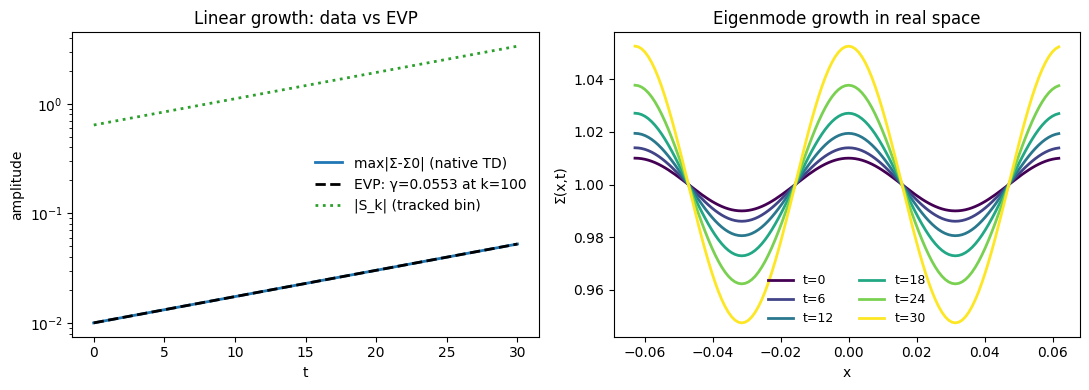

In [34]:
# --- (a) growth curve vs EVP prediction
fig, ax = plt.subplots(1, 2, figsize=(11,4))

# growth from max|s(x)|
ax[0].plot(T, np.maximum(Smax, 1e-20), lw=2, label="max|Σ-Σ0| (native TD)")
ax[0].set_yscale("log")
ax[0].set_xlabel("t")
ax[0].set_ylabel("amplitude")

# EVP prediction at k_track (fallback: use nearest bin to requested --k, if present)
if k_track is not None:
    w, V = evp_solve_at_k(cfg, k_track)
    gamma = w[0].real  # dominant growth rate
    # Match normalization to first snapshot
    a0 = Smax[0] if Smax[0] > 0 else (Smax[Smax>0][0] if np.any(Smax>0) else 1e-12)
    ax[0].plot(T, a0 * np.exp(gamma*(T - T[0])), "k--", lw=2,
               label=f"EVP: γ={gamma:.3g} at k={k_track:.3g}")
else:
    # optional fallback: estimate k_track from metrics abscent — skip EVP overlay
    pass

# If we have spectral amplitude tracking from metrics, show it too
if (t_metrics is not None) and (amp_track is not None) and len(amp_track):
    ax[0].plot(t_metrics, np.maximum(amp_track, 1e-20), "C2:", lw=2, label="|S_k| (tracked bin)")

ax[0].legend(frameon=False)
ax[0].set_title("Linear growth: data vs EVP")

# --- (b) spatial snapshots of Σ(x,t)
# choose ~6 evenly spaced snapshots
nsamp = 6
idxs = np.linspace(0, len(T)-1, nsamp, dtype=int)
cmap = plt.cm.viridis
tmin, tmax = float(T[0]), float(T[-1])

for j, i in enumerate(idxs):
    c = cmap(j/(nsamp-1) if nsamp>1 else 0.0)
    ax[1].plot(x, Sigma_snapshots[i], color=c, lw=2, label=f"t={T[i]:.3g}")

ax[1].set_xlabel("x")
ax[1].set_ylabel("Σ(x,t)")
ax[1].set_title("Eigenmode growth in real space")
ax[1].legend(ncol=2, frameon=False, fontsize=9)

plt.tight_layout()
plt.show()